### Empirical Model
How can we apply an empirical model to increase the performance of the model?


### Antoine Equation
$$
ln(P^{*}) = A-\frac{B}{T+C}
$$

We need to remove the column in the dataset, which contains the Vapor Pressure measurements

In [1]:
import pandas as pd
import torch
import numpy as np

data = pd.read_csv('distillation-tower.csv')

X = data.drop('VapourPressure', axis=1)
X = X.iloc[:, 1:]
y = data['VapourPressure']

/tmp/ipykernel_613825/3158967938.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Now, we need to develop our empirical model by regressing ln(P) vs 1/T.

In [2]:
invt = data['InvTemp3']
vp = data['VapourPressure']

In [3]:
vp = np.log(vp)

In [4]:
from sklearn.linear_model import LinearRegression

invt = np.array(invt).reshape(-1, 1)
vp = np.array(vp)

model = LinearRegression()

model.fit(invt, vp)

vp_pred = model.predict(invt)
X['Antoine'] = vp_pred

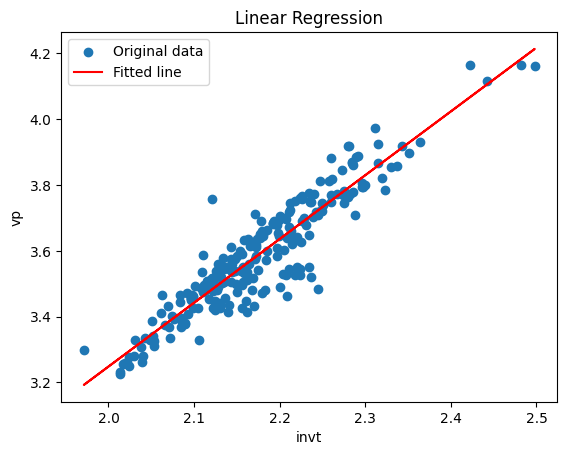

R-squared: 0.8649881279307753


In [5]:
import matplotlib.pyplot as plt

plt.scatter(invt, vp, label='Original data')

# Plotting the regression line
plt.plot(invt, vp_pred, color='red', label='Fitted line')

plt.xlabel('invt')
plt.ylabel('vp')
plt.title('Linear Regression')
plt.legend()

plt.show()

# If you want to evaluate the model you can use metrics like R-squared
r_squared = model.score(invt, vp)
print(f'R-squared: {r_squared}')

From our graph, we can see that the regression model is pretty good at fitting the data.
Now we can use the model to predict the vapor pressure and use this in our neural network.
The goal is for the neural network to use our pressure as a starting point.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
import torch.nn as nn

class VaporPressureNet(nn.Module):
    def __init__(self):
        super(VaporPressureNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
model = VaporPressureNet()

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 3000

for epoch in range(epochs):
    model.train() 
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

model.eval() 
with torch.no_grad(): 
    predictions = []
    targets = []
    for inputs, true_values in test_dataloader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        targets.extend(true_values.tolist())

from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(targets, predictions)
mae = mean_absolute_error(targets, predictions)
print(f'R^2 Score on test set: {r2:.4f}')
print(f'Mean absolute error on test set: {mae: .4f}')

Epoch 1/3000, Loss: 192.4001
Epoch 2/3000, Loss: 95.2840
Epoch 3/3000, Loss: 74.2854
Epoch 4/3000, Loss: 75.7719
Epoch 5/3000, Loss: 71.0980
Epoch 6/3000, Loss: 64.2810
Epoch 7/3000, Loss: 64.6735
Epoch 8/3000, Loss: 63.0034
Epoch 9/3000, Loss: 62.2162
Epoch 10/3000, Loss: 62.4005
Epoch 11/3000, Loss: 63.6954
Epoch 12/3000, Loss: 65.1691
Epoch 13/3000, Loss: 65.8269
Epoch 14/3000, Loss: 59.0165
Epoch 15/3000, Loss: 59.2635
Epoch 16/3000, Loss: 62.8728
Epoch 17/3000, Loss: 60.0610
Epoch 18/3000, Loss: 64.9199
Epoch 19/3000, Loss: 71.1359
Epoch 20/3000, Loss: 70.6513
Epoch 21/3000, Loss: 62.6376
Epoch 22/3000, Loss: 67.6182
Epoch 23/3000, Loss: 60.2354
Epoch 24/3000, Loss: 54.5756
Epoch 25/3000, Loss: 54.5539
Epoch 26/3000, Loss: 54.4039
Epoch 27/3000, Loss: 54.2401
Epoch 28/3000, Loss: 52.1942
Epoch 29/3000, Loss: 52.4012
Epoch 30/3000, Loss: 54.9080
Epoch 31/3000, Loss: 50.5162
Epoch 32/3000, Loss: 57.1953
Epoch 33/3000, Loss: 51.8962
Epoch 34/3000, Loss: 50.0621
Epoch 35/3000, Loss: 4

In [37]:
def evaluate(n):
    single_observation = X_test.iloc[n]
    single_observation = single_observation.apply(pd.to_numeric, errors='coerce').fillna(0)
    single_observation_tensor = torch.tensor(single_observation.values, dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction = model(single_observation_tensor)     
    # lnp = vp_pred[80]
    print("Predicted Vapour Pressure:", prediction.item())
    print("Experimental Vapour pressure:", y_test.iloc[n])
    # print("Antoine Model Prediction:", np.exp(lnp))

In [38]:
evaluate(18)

Predicted Vapour Pressure: 29.700136184692383
Experimental Vapour pressure: 29.0263
31.329589497031964
-2.3032894970319653


,Temp1,FlowC1,Temp2,TempC1,Temp3,TempC2,TempC3,Temp4,PressureC1,Temp5,...,Temp9,Temp10,FlowC3,FlowC4,Temp11,Temp12,InvTemp1,InvTemp2,InvTemp3,InvPressure1
0,139.9857,432.0636,377.8119,100.2204,492.1353,490.1459,180.5578,187.4331,215.0627,489.0043,...,461.2371,513.9653,8.6279,10.5988,30.8983,489.9900,2.0409,2.6468,2.1681,4.3524
1,131.0470,487.4029,371.3060,100.2297,482.2100,480.3128,172.6575,179.5089,205.0999,479.0443,...,450.3000,504.5145,8.7662,10.7560,31.9099,480.2888,2.0821,2.6932,2.2207,4.5497
2,118.2666,437.3516,378.4483,100.3084,488.7266,487.0040,165.9400,172.9262,205.0304,485.1326,...,458.8101,508.9997,8.5319,10.5737,29.9165,486.6190,2.0550,2.6424,2.1796,4.5511
3,118.1769,481.8314,378.0028,95.5766,493.1481,491.1137,167.2085,174.2338,205.2561,490.4338,...,462.5252,514.1794,8.6260,10.6695,30.6229,491.1304,2.0361,2.6455,2.1620,4.5464
4,120.7891,412.6471,377.8871,92.9052,490.2486,488.6641,167.0326,173.9681,205.0883,486.1049,...,460.7509,511.0948,8.5939,10.4922,29.4977,487.6475,2.0507,2.6463,2.1704,4.5499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,130.8138,212.6385,341.5964,121.4354,468.3401,467.0299,174.7639,180.7649,229.7393,465.4282,...,451.9269,479.0290,5.5590,6.4470,16.4131,466.3347,2.1444,2.9274,2.2127,4.0911
249,128.9673,225.1412,349.8965,118.8604,479.7665,478.4652,176.2176,182.3646,230.5049,477.2564,...,462.5281,491.2362,5.6342,6.4360,17.2385,477.8816,2.0926,2.8580,2.1620,4.0783
250,130.5328,223.5965,345.9366,120.4027,474.5378,473.1145,176.3310,182.2578,230.6638,471.4597,...,457.5511,485.8786,5.4810,6.3575,16.9866,472.3176,2.1172,2.8907,2.1855,4.0756
251,128.5248,213.5613,343.4950,119.6989,469.3802,467.9954,174.6435,180.5093,230.5226,466.4124,...,452.7025,480.2879,5.4727,6.4175,16.6778,467.0001,2.1413,2.9113,2.2090,4.0780
